In [1]:
# Import various libraries
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [234]:
file_cmt = './data/Venus_data/venusquake-scaling/earthquake_data/quakes-subduction.csv'
cmt = pd.read_csv(file_cmt)
cmt

C:\Users\quentin\AppData\Local\Temp\ipykernel_12464\1746899077.py:2: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  cmt = pd.read_csv(file_cmt)


,Year,Month,Day,Time,Latitude,Longitude,Depth,mb,MS,Region,...,Eigenvalue 3,Plunge 3,Azimuth 3,Moment,Strike 1,Dip 1,Rake 1,Strike 2,Dip 2,Rake 2
0,1976,1,1,01:29:39.6,-28.61,-177.64,59.0,6.2,0.0,KERMADECISLANDSREGION,...,-10.190,15,110,9.560000e+19,202,30,93,18,60,88
1,1976,1,5,02:31:36.3,-13.29,-74.90,95.0,6.0,0.0,PERU,...,-2.620,66,20,3.790000e+17,350,28,-60,137,66,-105
2,1976,1,6,21:08:19.3,51.60,159.33,33.0,5.7,6.0,OFFEASTCOASTOFKAMCHA,...,-2.000,27,126,1.980000e+18,206,18,78,39,73,94
3,1976,1,9,23:54:35.6,-15.76,167.87,168.0,6.1,0.0,VANUATUISLANDS,...,-2.830,67,329,3.640000e+18,246,22,-86,62,68,-91
4,1976,1,14,15:56:34.9,-29.21,-177.89,69.0,6.3,0.0,KERMADECISLANDS,...,-5.980,19,106,6.020000e+20,200,26,95,15,64,88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38213,2020,12,30,00:35:28.4,36.49,140.58,50.0,0.0,5.2,NEAREASTCOASTOFHONSH,...,-0.894,13,109,8.930000e+16,200,32,92,18,58,89
38214,2020,12,30,19:10:20.7,-2.40,127.49,16.4,0.0,4.8,CERAMSEA,...,-1.623,11,273,1.546000e+16,317,76,-2,48,89,-166
38215,2020,12,31,10:18:54.5,-8.74,122.28,130.1,0.0,5.1,"FLORESREGION,INDONESIA",...,-8.254,42,140,8.634000e+16,165,42,-17,268,79,-130
38216,2020,12,31,19:50:17.4,-0.80,146.84,10.0,0.0,5.2,ADMIRALTYISLANDSREGION,...,-7.289,28,10,7.449000e+16,90,18,78,283,73,94


In [170]:
from openquake.hmtk.seismicity.catalogue import Catalogue
from openquake.hmtk.seismicity.declusterer import GardnerKnopoffType1

In [171]:
cmt.rename(columns=dict(Year='year', Month='month', Day='day', Longitude='longitude', Latitude='latitude', Depth='depth'), inplace=True)
cmt[['hour', 'minute', 'second']] = cmt['Time'].str.split(':', expand=True)
cmt.loc[:,'second'] = cmt['second'].str.split('.', expand=True)[0]
cols = ['hour', 'minute', 'second', 'year', 'month', 'day', 'longitude', 'latitude', 'depth']
for col in cols:
    cmt.loc[:,col] = cmt[col].astype(int)

cols = ['longitude', 'latitude', 'depth']
for col in cols:
    cmt.loc[:,col] = cmt[col].astype(float)

cmt['magnitude'] = np.max(cmt[['mb','MS']].values, axis=1)
cmt['eventID'] = cmt.index.values

cmt['datetime'] = pd.to_datetime(cmt[['year', 'month', 'day']].astype(str).agg('-'.join, axis=1) + ' ' + cmt['Time'])
earliest_time = cmt['datetime'].min()
cmt['seconds_since_earliest'] = (cmt['datetime'] - earliest_time).dt.total_seconds()
cmt['days_since_earliest'] = cmt['seconds_since_earliest']/(3600*24)
cmt['magnitude'] = np.max(cmt[['mb','MS']].values, axis=1)

file_cmt = './data/Venus_data/venusquake-scaling/earthquake_data/quakes-subduction_openquake.csv'
cols = ['eventID', 'magnitude', 'hour', 'minute', 'second', 'year', 'month', 'day', 'longitude', 'latitude', 'depth']
cmt[cols].to_csv(file_cmt, header=True, index=False)

In [172]:
from openquake.hmtk.parsers.catalogue import CsvCatalogueParser

"""catalog = Catalogue.from_dict({
    'origin_time': cmt['datetime'].values,
    'longitude': cmt['Longitude'].values,
    'latitude': cmt['Latitude'].values,
    'magnitude': cmt['magnitude'].values
})"""

file_cmt = './data/Venus_data/venusquake-scaling/earthquake_data/quakes-subduction_openquake.csv'
parser = CsvCatalogueParser(file_cmt)
catalogue = parser.read_file(start_year=1900, end_year=2022)

In [173]:
from openquake.hmtk.seismicity.declusterer.distance_time_windows import GardnerKnopoffWindow

declust_config = {'time_distance_window': GardnerKnopoffWindow(),'fs_time_prop':1.0}
gk_declusterer = GardnerKnopoffType1()
declustered_catalog, flag = gk_declusterer.decluster(catalogue, declust_config)

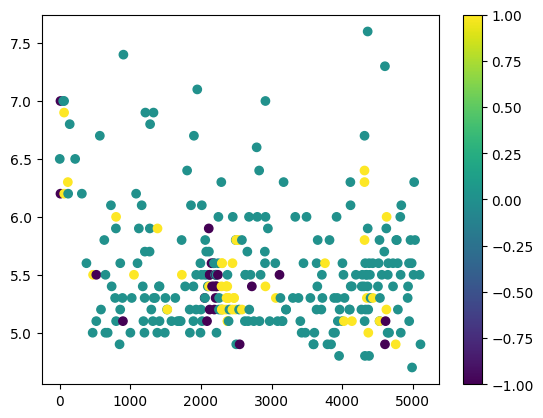

In [174]:
cmt_declustered = cmt.iloc[np.where(flag==0)]
#np.unique(declustered_catalog), np.unique(flag)
imax = 300
plt.figure()
sc = plt.scatter(cmt.iloc[:imax].days_since_earliest, cmt.iloc[:imax].magnitude, c=flag[:imax])
plt.colorbar(sc)

In [20]:
from scipy.spatial import cKDTree

def haversine(lat1, lon1, lat2, lon2):
    """Calculate the great-circle distance between two points on the Earth using the Haversine formula."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * 6371 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))  # Earth radius is 6371 km

def decluster_fast(df):
    declustered = []
    is_aftershock = np.zeros(len(df), dtype=bool)  # Array to mark aftershocks

    # Precompute datetimes and coordinates as NumPy arrays for faster access
    datetimes = df['days_since_earliest'].values
    magnitudes = df['magnitude'].values
    coords = np.radians(df[['Latitude', 'Longitude']].values)  # Convert lat/lon to radians for Haversine
    kdtree = cKDTree(coords)  # Build KD-tree for spatial queries

    for i in tqdm(range(len(df))):
        if not is_aftershock[i]:
            # Retain this event as a mainshock
            declustered.append(df.iloc[i])

            mainshock_mag = magnitudes[i]
            mainshock_time = datetimes[i]
            mainshock_coord = coords[i]

            # Define time and distance windows based on magnitude
            time_window = 10 ** (0.1238 * mainshock_mag + 0.983)  # in days
            distance_window = 10 ** (0.1238 * mainshock_mag + 0.983)  # in km

            # Find events within the time window using binary search
            time_diff = datetimes - mainshock_time
            within_time_window = np.where((time_diff > 0) & (time_diff <= time_window))[0]

            # Query KD-tree to find events within the distance window
            indices_within_distance = kdtree.query_ball_point(mainshock_coord, distance_window / 6371)

            # Combine time and distance filtering
            candidates = np.intersect1d(within_time_window, indices_within_distance)

            # Mark these events as aftershocks
            is_aftershock[candidates] = True

    return pd.DataFrame(declustered)

# Usage
declustered_df = decluster_fast(cmt)


100%|██████████| 38218/38218 [00:32<00:00, 1182.55it/s]


In [60]:
forRF_declustering = cmt[['days_since_earliest', 'magnitude', 'Latitude', 'Longitude']]
forRF_declustering = forRF_declustering.rename(columns={'days_since_earliest': 'time', "Latitude": "latitude", "Longitude": "longitude"})
forRF_declustering.to_csv('./catalog_for_RF_declustering.csv', header=True, index=False)

In [17]:
from tqdm import tqdm
def decluster(df):
    declustered = []
    is_aftershock = np.zeros(len(df), dtype=bool)  # Array to mark aftershocks

    for i in tqdm(range(len(df))):
        if not is_aftershock[i]:
            # This event is a mainshock, so we retain it
            declustered.append(df.iloc[i])

            # Get mainshock magnitude, time, and location
            mainshock_mag = df.iloc[i]['magnitude']
            mainshock_time = df.iloc[i]['days_since_earliest']
            mainshock_lat = df.iloc[i]['Latitude']
            mainshock_lon = df.iloc[i]['Longitude']

            # Define time and distance windows based on magnitude
            time_window = 10 ** (0.1238 * mainshock_mag + 0.983)  # in days
            distance_window = 10 ** (0.1238 * mainshock_mag + 0.983)  # in km

            for j in range(i + 1, len(df)):
                # Compute time difference in days
                #time_diff = (df.iloc[j]['datetime'] - mainshock_time).total_seconds() / (60 * 60 * 24)
                time_diff = df.iloc[j]['days_since_earliest'] - mainshock_time
                
                if time_diff > time_window:
                    break  # No need to check further; we're outside the time window
                
                # Compute distance between mainshock and candidate aftershock (Haversine formula)
                lat1, lon1 = np.radians([mainshock_lat, mainshock_lon])
                lat2, lon2 = np.radians([df.iloc[j]['Latitude'], df.iloc[j]['Longitude']])
                dlat = lat2 - lat1
                dlon = lon2 - lon1
                a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
                c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
                earth_radius_km = 6371.0
                distance = earth_radius_km * c  # Distance in kilometers

                if distance <= distance_window:
                    # Mark as aftershock
                    is_aftershock[j] = True

    return pd.DataFrame(declustered)

# Usage
declustered_cmt = decluster(cmt)

  1%|          | 258/38218 [00:27<1:08:11,  9.28it/s]


KeyboardInterrupt: 

In [150]:
import scipy

ns = np.arange(0, 30, 1).astype(int)
days = cmt.days_since_earliest.max()

#plt.figure()
N_total = cmt.shape[0]
N_ws = [5000]
for N_w in N_ws:
    
    mean = N_total/N_w
    factor = np.exp(-mean)
    n_days = days/mean

    poisson_cum = np.zeros(ns.size)
    for ii, nn in enumerate(ns[:-1]):
        fact = scipy.special.factorial(ns[ns>=nn])
        #print(fact)
        #print(factor*(mean**ns[ns>nn])/fact)
        #print(np.sum(factor*(mean**ns[ns>nn])/fact))
        sum = factor*np.sum((mean**ns[ns>=nn])/fact)
        poisson_cum[ii] = sum

    Kminus = poisson_cum*N_w
    Kminus_selected = np.where((Kminus[:]>=5))[0].max()
    Kplus_selected = np.where((N_w-Kminus>=5))[0][-2]
    #Kplus_selected = N_w-Kminus[Kminus_selected-1]
    print(f'Kminus_selected {Kminus_selected} Kplus_selected {Kplus_selected}')
    print(f'val for Kminus_selected: {Kminus[Kminus_selected]}')
    print(f'val for Kplus_selected: {N_w-Kminus[Kplus_selected-1]}')

    #plt.plot(ns[:-1], poisson_cum[:-1], label=f'nevents: {mean:.2f} months: {n_days/30:.0f}')
##plt.yscale('log')
#plt.legend()

Kminus_selected 17 Kplus_selected 28
val for Kminus_selected: 11.858196244176018
val for Kplus_selected: 4999.999790993102


In [1]:
from obspy.clients.fdsn import Client

# Initialize the NCEDC FDSN client
client = Client("IRIS")

# Example: Get event catalog for a specific time range
catalog = client.get_events(starttime="1900-01-01", endtime="2023-01-31", minmagnitude=4.0)


In [236]:
times = [(event.origins[0].time-catalog[0].origins[0].time)/(3600*24*30) for event in catalog]
len(times)

10000

In [196]:
import numpy as np
from scipy.stats import chi2

# Parameters
#cmt_declustered_ = cmt_declustered
#total_time = cmt_declustered_.days_since_earliest.max()/30
total_time = np.max(times)
N_w = 2000
#observed_counts, bin_edges = np.histogram(cmt_declustered_.days_since_earliest.values/30, bins=N_w)
observed_counts, bin_edges = np.histogram(times, bins=N_w)
total_events = observed_counts.sum()  # Total number of events

# Compute the average rate (lambda) under the Poisson process
lambda_rate = total_events / total_time

# Compute expected counts for each bin assuming a Poisson process
expected_counts = lambda_rate * np.diff(bin_edges)

# Compute the chi-square statistic
#print(observed_counts)
#print(expected_counts)
chi_square_stat = np.sum((observed_counts - expected_counts)**2 / expected_counts)

# Degrees of freedom: number of bins - 1
degrees_of_freedom = len(observed_counts) - 1

# Compute p-value from chi-square distribution
p_value = 1 - chi2.cdf(chi_square_stat, degrees_of_freedom)

# Display results
print(f"Chi-square statistic: {chi_square_stat}")
print(f"Degrees of freedom: {degrees_of_freedom}")
print(f"P-value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Reject the null hypothesis: The time distribution is not Poissonian.")
else:
    print("Fail to reject the null hypothesis: The time distribution is consistent with a Poisson process.")


Chi-square statistic: 3180.9395693447855
Degrees of freedom: 1999
P-value: 0.0
Reject the null hypothesis: The time distribution is not Poissonian.


In [178]:
import obspy
file = '../data_venus/jan76_dec20.ndk'
cat = obspy.read_events(file)
print(cat)

56832 Event(s) in Catalog:
1976-01-01T01:29:53.400000Z | -29.250, -176.960 | 7.25 Mwc
1976-01-05T02:31:44.700000Z | -13.420,  -75.140 | 5.65 Mwc
...
2020-12-31T19:50:21.800000Z |  -0.680, +146.830 | 5.18 Mwc
2020-12-31T23:12:39.300000Z |  -9.020, +119.060 | 4.96 Mwc
To see all events call 'print(CatalogObject.__str__(print_all=True))'


In [212]:
file = '../data_venus/NDEC_catalog.csv'
cmt = pd.read_csv(file, header=[0], delim_whitespace=True)
cmt['datetime'] = pd.to_datetime(cmt['Date'] + 'T' + cmt['Time'])

# Find the earliest date in the 'time' column
earliest_event = cmt['datetime'].min()

# Compute the difference in months for each event (using 30.44 days per month on average)
cmt['months'] = (cmt['datetime'] - earliest_event).dt.days / 30.44
cmt

,Date,Time,Lat,Lon,Depth,Mag,Magt,Nst,Gap,Clo,RMS,SRC,Event,ID,datetime,months
0,1967/08/22,08:29:47.47,36.40050,-120.98650,36.357,3.00,Mx,9,298,16.0,0.63,NCSN,1001120.0,NaN,1967-08-22 08:29:47.470,0.000000
1,1967/08/26,10:35:05.61,36.53867,-121.16033,4.277,3.30,Mx,13,80,2.0,0.05,NCSN,1001154.0,NaN,1967-08-26 10:35:05.610,0.131406
2,1967/08/27,13:20:08.75,36.51083,-121.14500,1.386,3.60,Mx,11,174,6.0,0.11,NCSN,1001166.0,NaN,1967-08-27 13:20:08.750,0.164258
3,1968/01/12,22:19:10.35,36.64533,-121.24966,6.578,3.00,ML,14,155,2.0,0.07,NCSN,1001353.0,NaN,1968-01-12 22:19:10.350,4.697766
4,1968/02/09,13:42:37.05,37.15267,-121.54483,8.256,3.00,ML,25,157,7.0,0.08,NCSN,1001402.0,NaN,1968-02-09 13:42:37.050,5.617608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23680,2023/12/28,07:00:41.89,40.41500,-125.24717,10.000,3.75,ML,179,236,77.0,0.27,NCSN,73981981.0,NaN,2023-12-28 07:00:41.890,676.116951
23681,2023/12/28,12:03:26.22,40.40250,-125.10833,10.000,3.50,ML,118,243,66.0,0.23,NCSN,73982061.0,NaN,2023-12-28 12:03:26.220,676.149803
23682,2023/12/29,07:10:11.88,38.81400,-122.79884,2.080,3.89,Mw,108,27,1.0,0.06,NCSN,73982331.0,NaN,2023-12-29 07:10:11.880,676.149803
23683,2023/12/30,02:26:27.30,35.39967,-118.64450,8.410,3.69,ML,24,33,14.0,0.11,NCSN,73982846.0,NaN,2023-12-30 02:26:27.300,676.182654


In [231]:
from tqdm import tqdm
directory = 'https://ncedc.org/ftp/pub/catalogs/NCSS-catalogs/'
years = np.arange(1966, 2024)
cat = pd.DataFrame()
for year in tqdm(years):
    url = f'{directory}{year}.ehpcsv'
    cat_loc = pd.read_csv(url)
    cat = pd.concat([cat, cat_loc])
cat.reset_index(drop=True, inplace=True)

100%|██████████| 58/58 [00:32<00:00,  1.80it/s]


In [228]:
times = [(event.origins[0].time-cat[0].origins[0].time)/(3600*24*30) for event in catalog]
len(times)

8266

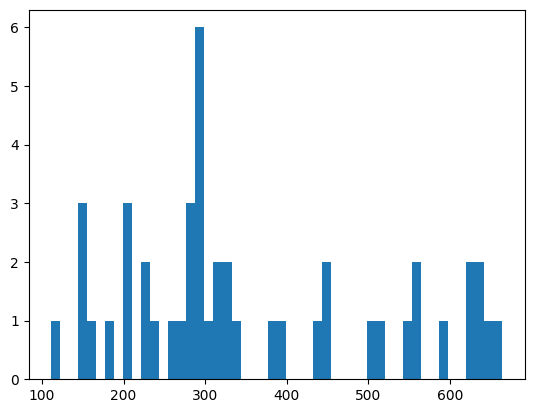

In [219]:
plt.figure()
_ = plt.hist(cmt.loc[cmt.Mag>6].months.values, bins=50)

In [217]:
# create an example dataset
times = cmt.months.values
nobs = len(times)
times_ia = np.diff(times)
times_a = np.cumsum(times_ia) # arrival times
t_total = times_a.max()

#bin_limits = np.array([ 0. ,  0.5,  1. ,  1.5,  2. ,  np.inf])
#nfreq_ia, bins_ia = np.histogram(times_ia, bin_limits)
nfreq_ia, bins_ia = np.histogram(times_ia, bins=100)

# implication: arrival times are uniform for fixed interval
# using times.max() means we don't really have a fixed interval
print(stats.kstest(times_a, stats.uniform(0, t_total).cdf))

# implication: inter-arrival times are exponential
lambd = nobs * 1. / t_total
scale = 1. / lambd

expected_ia = np.diff(stats.expon.cdf(bins_ia, scale=scale)) * nobs

# implication: given total number of events, distribution of times is uniform
# binned version
n_bins_a = nobs // 10
bin_limits_a = np.linspace(0, t_total+1e-7, n_bins_a + 1)
nfreq_a, bin_limits_a = np.histogram(times_a, bin_limits_a)
# expect uniform distributed over every subinterval
expected_a = np.ones(n_bins_a) / n_bins_a * nobs
expected_a *= nfreq_a.sum() / expected_a.sum()  # Ensuring both sums are the same
print(nfreq_a.sum(), expected_a.sum())
print(stats.chisquare(nfreq_a, expected_a, ddof=1))

KstestResult(statistic=0.10046021421025508, pvalue=1.5531825604147496e-208, statistic_location=386.7608409986859, statistic_sign=1)
23684 23684.000000000007
Power_divergenceResult(statistic=56556.8458030738, pvalue=0.0)


In [28]:
inter_event_times = np.diff(declustered_df.seconds_since_earliest.values)

# Step 2: Estimate lambda (rate parameter of Poisson process)
lambda_estimate = 1 / np.mean(inter_event_times)

# Step 3: Perform Kolmogorov-Smirnov test to compare empirical distribution of inter-event times with exponential distribution
#ks_stat, p_value = stats.kstest(inter_event_times, 'expon', args=(0, 1/lambda_estimate))
ks_stat, p_value = stats.kstest(declustered_df.seconds_since_earliest.values, stats.uniform(0, declustered_df.seconds_since_earliest.values.max()).cdf)

# Output results
print(f"KS Statistic: {ks_stat}")
print(f"P-value: {p_value}")

KS Statistic: 0.18558843354231114
P-value: 0.0


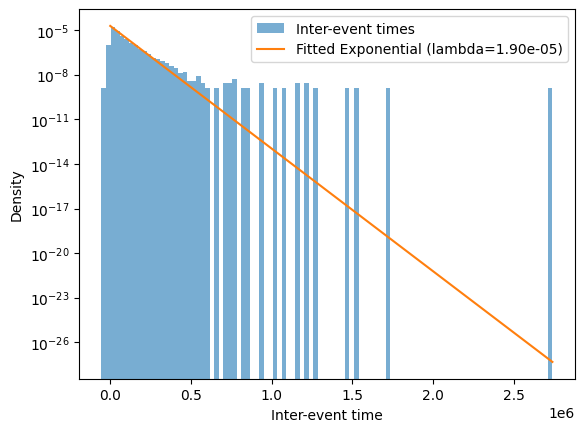

In [27]:
plt.figure()

# Step 4: Plot histogram of inter-event times and fitted exponential distribution for visualization
plt.hist(declustered_df.seconds_since_earliest.values, bins=100, density=True, alpha=0.6, label='Inter-event times')

# Generate fitted exponential distribution
x_vals = np.linspace(0, np.max(inter_event_times), 1000)
#plt.plot(x_vals, stats.expon.pdf(x_vals, scale=1/lambda_estimate), label=f'Fitted Exponential (lambda={lambda_estimate:.2e})')
plt.plot(x_vals, stats.uniform.pdf(x_vals, scale=1/lambda_estimate), )

plt.xlabel('Inter-event time')
plt.ylabel('Density')
plt.yscale('log')
plt.legend()